<a href="https://colab.research.google.com/github/TechT3o/white_and_generate_teeth/blob/main/teeth_detection_genai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding the mouth

In [ ]:
!pip install dlib
!pip install opencv-python

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2024-02-02 14:58:53--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  18.8MB/s    in 3.2s    

2024-02-02 14:58:56 (18.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
!pip install mediapipe
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [ ]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import cv2

def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

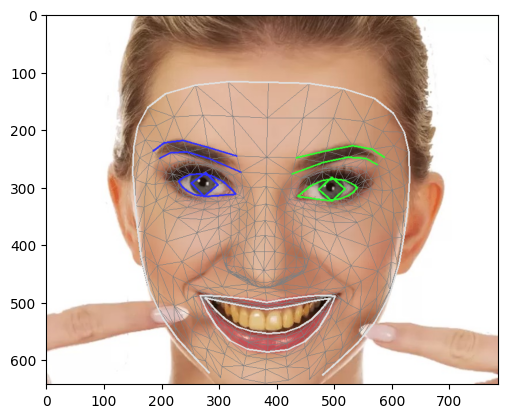

In [ ]:
# image_path = "men-human-face-smiling.jpg"
image_path = "yelt.jpg"

# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(image_path)

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)[:,:,::-1])
plt.show()

[[307, 499], [327, 503], [352, 508], [383, 512], [414, 508], [440, 503], [461, 498], [479, 495], [483, 494], [475, 515], [460, 530], [439, 543], [414, 552], [385, 554], [356, 550], [331, 542], [310, 528], [294, 513], [276, 492], [289, 495]]


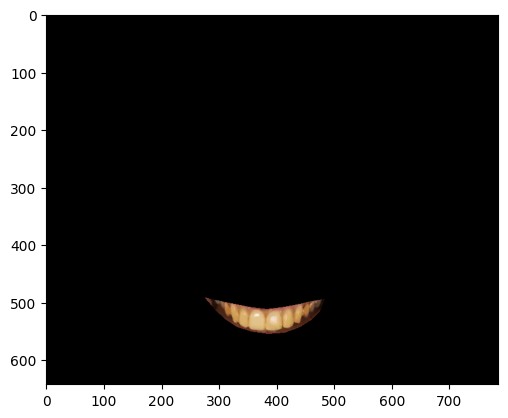

In [ ]:
cv_image = cv2.imread(image_path)
gray = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)

# Extract and draw the lips region
face_landmarks = detection_result.face_landmarks

inner_lips_indices = [80, 81, 82, 13, 312, 311, 310, 415, 407, 324, 318, 402, 317, 14, 87, 178, 88, 95, 78, 191]
inner_lips_points = []
for idx in inner_lips_indices:
  inner_lips_points.append([int(image.width * face_landmarks[0][idx].x), int(image.height * face_landmarks[0][idx].y)])
print(inner_lips_points)
lips_mask = np.zeros_like(gray)
lips_mask = cv2.fillPoly(lips_mask, [np.array(inner_lips_points)], 255)

# Apply the mask to the original image
lips_image = cv2.bitwise_and(cv_image, cv_image, mask=lips_mask)


plt.imshow(lips_image[:,:,::-1])

plt.show()

# Find teeth and whiten

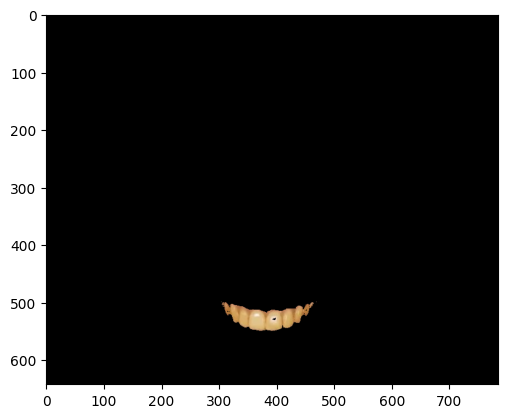

In [ ]:
# Convert the image from BGR to HSV color space
hsv_lips_img = cv2.cvtColor(lips_image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds of the color you want to threshold
# prev 11,12,40
lower_bound = np.array([11, 12, 143])  # Lower bound for hue, saturation, and value
# prev 51, 185, 255
upper_bound = np.array([51, 185, 255])  # Upper bound for hue, saturation, and value

# Create a binary mask using inRange function
hsv_mask = cv2.inRange(hsv_lips_img, lower_bound, upper_bound)

# Apply the mask to the original image
teeth_img = cv2.bitwise_and(lips_image, lips_image, mask=hsv_mask)

plt.imshow(teeth_img[:,:,::-1])
plt.show()

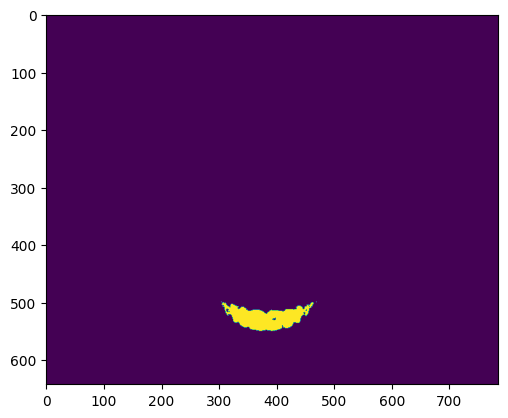

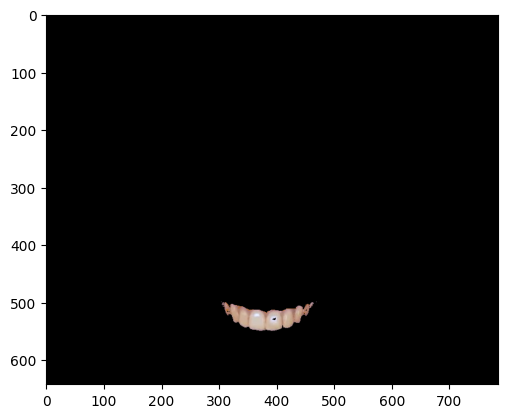

In [ ]:
import cv2
import numpy as np

def whiten_teeth(image, desaturation_strength=35, lightening_strength=20):

    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split into channels
    l, a, b = cv2.split(lab)

    # Identify yellowish areas (like teeth)
    # This threshold can be adjusted based on the image
    # yellow_mask = (b > 128) & ( b < 200) & (a > 108) & (a < 148) & (l>170)
    yellow_mask = (b > 128) & ( b < 200) & (a > 108) & (a < 148)
    plt.imshow(yellow_mask)
    plt.show()


    # Desaturate the yellowish areas
    b[yellow_mask] -=  25
    # l[yellow_mask] += 5
    # a[yellow_mask] = 0.3 -128



    # Clip values to stay within valid range
    b = np.clip(b, 0, 255)
    l = np.clip(l, 0, 255)

    # Merge the channels back
    updated_lab = cv2.merge((l, a, b))

    # Convert back to BGR color space
    updated_img = cv2.cvtColor(updated_lab, cv2.COLOR_LAB2BGR)

    return updated_img


whitened_img = whiten_teeth(teeth_img)
plt.imshow(whitened_img[:,:,::-1])
plt.show()

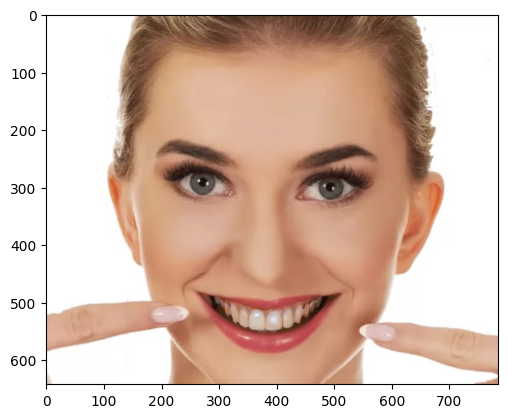

In [ ]:
# Apply the mask
masked_region_original = cv_image.copy() * (hsv_mask[:, :, None] != 0)
masked_region_modified = whitened_img * (hsv_mask[:, :, None] != 0)

# Replace the masked region
display_img = cv_image.copy() * (hsv_mask[:, :, None] == 0) + masked_region_modified

plt.imshow(display_img[:,:,::-1])
plt.show()

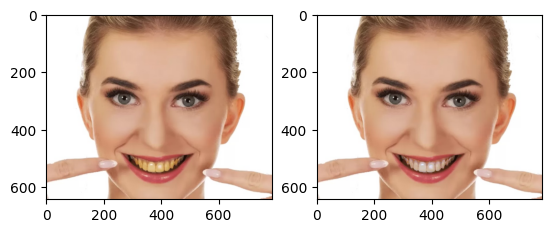

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(cv_image[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(display_img[:,:,::-1])
plt.show()

# Generate teeth with Stable Diffusion

In [ ]:
# !pip install ldm
# !pip install transformers

In [ ]:
!pip install diffusers

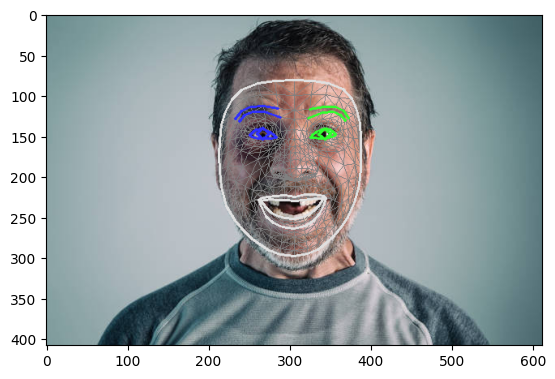

In [ ]:
image_path = "missing_teeth.jpg"

# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(image_path)

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)[:,:,::-1])
plt.show()

[[277, 228], [285, 229], [295, 229], [307, 230], [317, 229], [326, 228], [332, 227], [338, 227], [339, 226], [336, 236], [331, 241], [325, 246], [316, 250], [305, 252], [294, 251], [284, 248], [277, 244], [271, 238], [265, 230], [270, 229]]


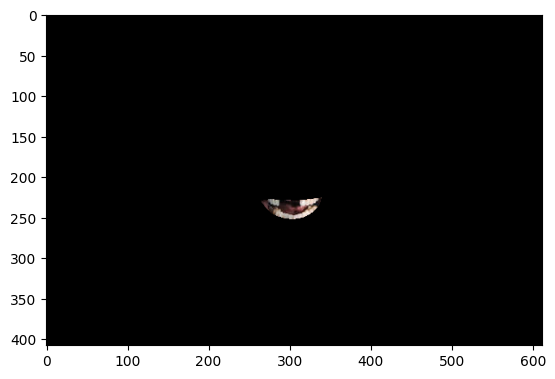

In [ ]:
cv_image = cv2.imread(image_path)
gray = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)

# Extract and draw the lips region
face_landmarks = detection_result.face_landmarks

inner_lips_indices = [80, 81, 82, 13, 312, 311, 310, 415, 407, 324, 318, 402, 317, 14, 87, 178, 88, 95, 78, 191]
inner_lips_points = []
for idx in inner_lips_indices:
  inner_lips_points.append([int(image.width * face_landmarks[0][idx].x), int(image.height * face_landmarks[0][idx].y)])
print(inner_lips_points)
lips_mask = np.zeros_like(gray)
lips_mask = cv2.fillPoly(lips_mask, [np.array(inner_lips_points)], 255)

# Apply the mask to the original image
lips_image = cv2.bitwise_and(cv_image, cv_image, mask=lips_mask)


plt.imshow(lips_image[:,:,::-1])
plt.show()

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import requests
import torch

# from ldm.models.diffusion.ddim import DDIMSampler
# from ldm.models.diffusion.plms import PLMSSampler

# Ensure you have accepted Hugging Face's terms and conditions for using the model
# and have the necessary API token if required

# model_id = "CompVis/stable-diffusion-v2-inpainting"
# model_id = "runwayml/stable-diffusion-inpainting"
model_id = "stabilityai/stable-diffusion-2-inpainting"

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

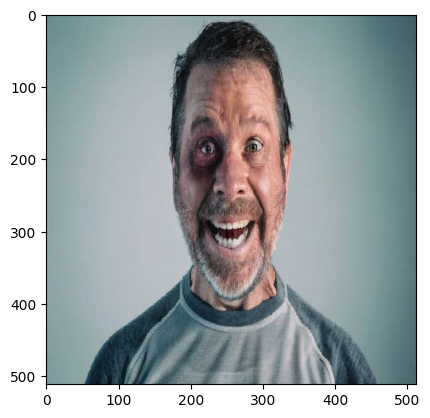

In [ ]:
# Perform inpainting
prompt = "a person with natural looking , healthy, shiny and well-aligned white teeth, hyperealistic"
neg_prompt = "Misaligned teeth, dirty teeth, yellow teeth, missing teeth"
result = pipe(image=cv_image[:,:,::-1]/255, mask_image=lips_mask, negative_prompt = neg_prompt,
              prompt= prompt, guidance_scale = 9, num_inference_steps = 60, strength = 0.8).images[0]

plt.imshow(result)
plt.show()

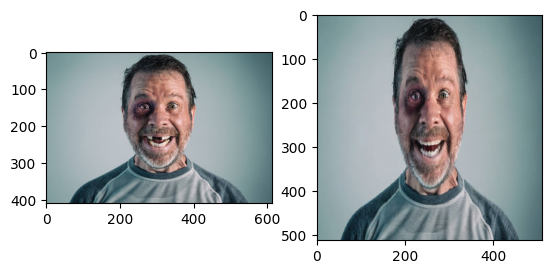

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(cv_image[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()